─────────────────────────────────────────────────────────────
# Deep BOLD Perceptual Similarity (DBPS) - Model Implementation

Basis:
  - Inspired by Zhang et al. (2018), "The Unreasonable Effectiveness of Deep Features
    as a Perceptual Metric" (https://arxiv.org/abs/1801.03924)
  - Instead of natural images (based on ImageNet), we apply the concept to fMRI BOLD slices.
  - Replace VGG features with a custom CNN feature extractor trained on fMRI GT data.

Goal:
  - Learn a feature extractor that measures perceptual similarity between
    GT (BOLD-activated) fMRI slices and denoised (or noised) slices.
  - Compute slice-wise similarity distances as a quantitative denoising metric.

This notebook builds:
  1. Data loading pipeline for GT slices.
  2. A simple CNN-based feature extractor.
  3. LPIPS-like feature-distance calculation (no 2AFC head).
  4. Training loop on GT data to learn domain-specific features.

─────────────────────────────────────────────────────────────

In [104]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [105]:
# ─── Device Setup ──────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [106]:
# ─── Load GT and Noisy data ────────────────────────────────────────────
gt = np.load('/kaggle/input/fmri-train-1-norm-v3/data/gt_func_train_1.npy', mmap_mode='r')
sr = np.load('/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy', mmap_mode='r')
print("GT shape:", gt.shape, "SR shape:", sr.shape)

GT shape: (64, 64, 156, 300) SR shape: (64, 64, 156, 300)


In [107]:
# ─── Dataset: GT slices only for feature training ──────────────────────
class FMRI2DSliceDataset(Dataset):
    def __init__(self, volume):
        self.volume = volume
        self.H, self.W, self.Z, self.T = volume.shape

    def __len__(self):
        return self.Z * self.T

    def __getitem__(self, idx):
        z = idx // self.T
        t = idx % self.T
        slice_2d = self.volume[:, :, z, t].astype(np.float32)
        return torch.from_numpy(slice_2d).unsqueeze(0)

In [108]:
# ─── Simple CNN Feature Extractor ──────────────────────────────────────
class SimpleFMRIEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x  # shape: (64, 8, 8)

In [109]:
# ─── Deeper CNN Feature Extractor for DBPS ──────────────────────────────
class DeepFMRIEncoder(nn.Module):
    """
    A deeper CNN feature extractor for fMRI slices.
    - Learns more abstract hierarchical features compared to the 3-layer version.
    - Better separates subtle noise from structural differences in BOLD data.
    - Designed as a lightweight alternative to VGG for perceptual metrics.
    """

    def __init__(self):
        super().__init__()
        # First conv block: detect basic edges and gradients
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Second conv block: capture more complex textures
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Third conv block: learn mid-level features (patterns, contrasts)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Fourth conv block: deeper features (regional activations, functional structures)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Pooling: downsample to maintain computational efficiency and focus on spatial patterns
        self.pool = nn.AvgPool2d(2)
        # Normalization: improve convergence and stability (optional but often helpful)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

    def forward(self, x):
        """
        Forward pass:
        Input:  (B, 1, 64, 64) - single-channel fMRI slices
        Output: (B, 128, 4, 4) - deep feature maps
        """
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # (B, 16, 32, 32)   
        x1 = x

        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # (B, 32, 16, 16)
        x2 = x
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)  # (B, 64, 8, 8)
        x3 = x
        
        # Fourth block
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)  # (B, 128, 4, 4)
        x4 = x
        
        return [x1, x2, x3, x4]


In [110]:
# ─── Pre-train CNN: simple auto-encoding (GT as input & target) ────────
dataset = FMRI2DSliceDataset(gt)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [111]:
encoder = DeepFMRIEncoder().to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

Epoch 1 - Recon Loss: 0.177278
Epoch 2 - Recon Loss: 0.173667
Epoch 3 - Recon Loss: 0.173063
Epoch 4 - Recon Loss: 0.172728
Epoch 5 - Recon Loss: 0.172613
Epoch 6 - Recon Loss: 0.172628
Early stopping: no improvement in 1 epochs.


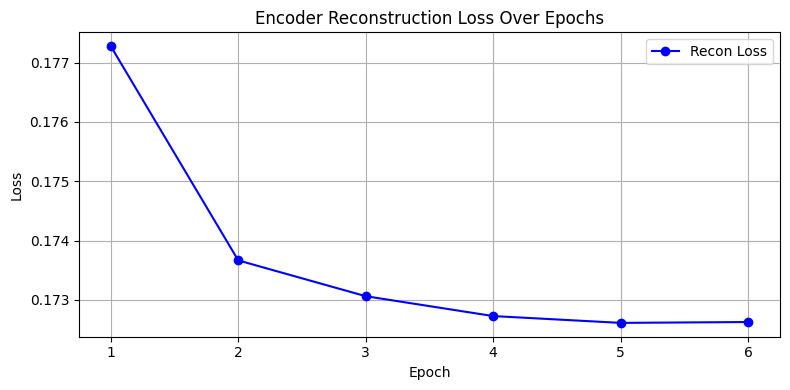

In [112]:
import matplotlib.pyplot as plt

best_loss = float('inf')    # start with infinity
patience = 1                # number of epochs to wait for improvement
wait = 0                    # counter for early stopping
loss_history = []
epoch = 0

while True:  # endless loop until stopped
    encoder.train()
    total_loss = 0.0

    for batch in loader:
        batch = batch.to(device)
        features = encoder(batch)[-1]
        target = F.avg_pool2d(batch, kernel_size=16).repeat(1, 128, 1, 1)
        loss = F.mse_loss(features, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(dataset)
    loss_history.append(avg_loss)
    epoch += 1

    print(f"Epoch {epoch} - Recon Loss: {avg_loss:.6f}")

    # Check for improvement
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        # (Optional) save model weights for the best state
        torch.save(encoder.state_dict(), "best_encoder.pth")
    else:
        wait += 1

    # Stop if no improvement for "patience" epochs
    if wait >= patience:
        print("Early stopping: no improvement in", patience, "epochs.")
        break

# ─── Plot final loss curve ─────────────────────────────
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', color='b', label='Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Encoder Reconstruction Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [129]:
class MultiLayerDBPSDistance(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor

        # separate channel-wise weights for each layer
        self.weight1 = nn.Parameter(torch.ones(16))
        self.weight2 = nn.Parameter(torch.ones(32))
        self.weight3 = nn.Parameter(torch.ones(64))
        self.weight4 = nn.Parameter(torch.ones(128))

        # final LPIPS-style linear head (learnable)
        self.lin_head = nn.Sequential(
            nn.Linear(4, 1),
            nn.ReLU()
        )

    def forward(self, img1, img2):
        feats1 = self.feature_extractor(img1)
        feats2 = self.feature_extractor(img2)

        layer_scores = []

        # Layer 1
        f1_norm = F.normalize(feats1[0], p=2, dim=1)
        f2_norm = F.normalize(feats2[0], p=2, dim=1)
        diff = (f1_norm - f2_norm) * self.weight1.view(1, -1, 1, 1)
        dist_map = diff.pow(2).sum(1, keepdim=True)
        score1 = dist_map.mean(dim=[2, 3]).squeeze(1)
        layer_scores.append(score1)

        # Layer 2
        f1_norm = F.normalize(feats1[1], p=2, dim=1)
        f2_norm = F.normalize(feats2[1], p=2, dim=1)
        diff = (f1_norm - f2_norm) * self.weight2.view(1, -1, 1, 1)
        dist_map = diff.pow(2).sum(1, keepdim=True)
        score2 = dist_map.mean(dim=[2, 3]).squeeze(1)
        layer_scores.append(score2)

        # Layer 3
        f1_norm = F.normalize(feats1[2], p=2, dim=1)
        f2_norm = F.normalize(feats2[2], p=2, dim=1)
        diff = (f1_norm - f2_norm) * self.weight3.view(1, -1, 1, 1)
        dist_map = diff.pow(2).sum(1, keepdim=True)
        score3 = dist_map.mean(dim=[2, 3]).squeeze(1)
        layer_scores.append(score3)

        # Layer 4
        f1_norm = F.normalize(feats1[3], p=2, dim=1)
        f2_norm = F.normalize(feats2[3], p=2, dim=1)
        diff = (f1_norm - f2_norm) * self.weight4.view(1, -1, 1, 1)
        dist_map = diff.pow(2).sum(1, keepdim=True)
        score4 = dist_map.mean(dim=[2, 3]).squeeze(1)
        layer_scores.append(score4)

        # stack scores and feed to linear head
        stacked_scores = torch.stack(layer_scores, dim=1)  # (B, 4)
        final_score = torch.stack([score1, score2, score3, score4], dim=1).mean(dim=1)


        return final_score

In [130]:
# ─── Example usage on GT vs. Noisy slice ───────────────────────────────
dbps_metric = MultiLayerDBPSDistance(encoder).to(device)
dbps_metric.eval()

MultiLayerDBPSDistance(
  (feature_extractor): DeepFMRIEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_head): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
)

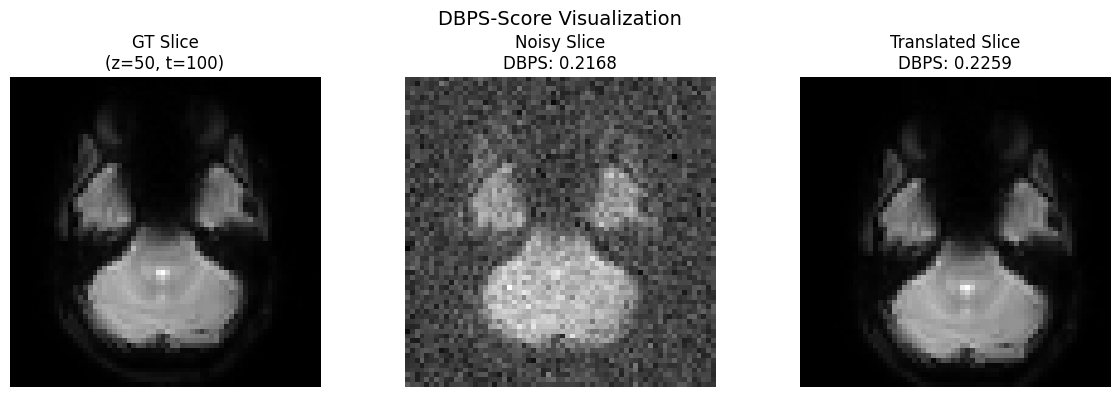

In [133]:
import matplotlib.pyplot as plt
import scipy.ndimage

# ─── Prepare the translated slice ───────────────────────
translated_slice = scipy.ndimage.shift(gt_slice, shift=(3, 3), order=1, mode='nearest')

# ─── Convert to tensor ──────────────────────────────────
translated_tensor = torch.from_numpy(translated_slice).unsqueeze(0).unsqueeze(0).to(device)

# ─── Compute DBPS Scores ────────────────────────────────
with torch.no_grad():
    score_noisy = dbps_metric(gt_tensor, noisy_tensor).item()
    score_translated = dbps_metric(gt_tensor, translated_tensor).item()

# ─── Plot GT, Noisy and Translated Slices ───────────────
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(gt_slice, cmap='gray')
axes[0].set_title(f"GT Slice\n(z={z}, t={t})")
axes[0].axis('off')

axes[1].imshow(noisy_slice, cmap='gray')
axes[1].set_title(f"Noisy Slice\nDBPS: {score_noisy:.4f}")
axes[1].axis('off')

axes[2].imshow(translated_slice, cmap='gray')
axes[2].set_title(f"Translated Slice\nDBPS: {score_translated:.4f}")
axes[2].axis('off')

plt.suptitle("DBPS-Score Visualization", fontsize=14)
plt.tight_layout()
plt.show()


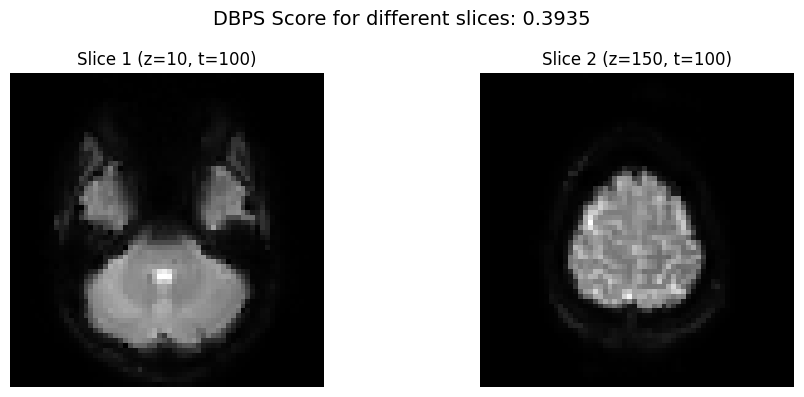

In [134]:
import matplotlib.pyplot as plt

# ─── Choose two very different slices ───────────────────────
z1, t1 = 10, 100
z2, t2 = 150, 100

slice1 = gt[:, :, z1, t1].astype(np.float32)
slice2 = gt[:, :, z2, t2].astype(np.float32)

tensor1 = torch.from_numpy(slice1).unsqueeze(0).unsqueeze(0).to(device)
tensor2 = torch.from_numpy(slice2).unsqueeze(0).unsqueeze(0).to(device)

# ─── Compute DBPS Score ─────────────────────────────────────
with torch.no_grad():
    score = dbps_metric(tensor1, tensor2).item()

# ─── Plot the two very different slices ─────────────────────
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(slice1, cmap='gray')
axes[0].set_title(f"Slice 1 (z={z1}, t={t1})")
axes[0].axis('off')

axes[1].imshow(slice2, cmap='gray')
axes[1].set_title(f"Slice 2 (z={z2}, t={t2})")
axes[1].axis('off')

plt.suptitle(f"DBPS Score for different slices: {score:.4f}", fontsize=14)
plt.tight_layout()
plt.show()


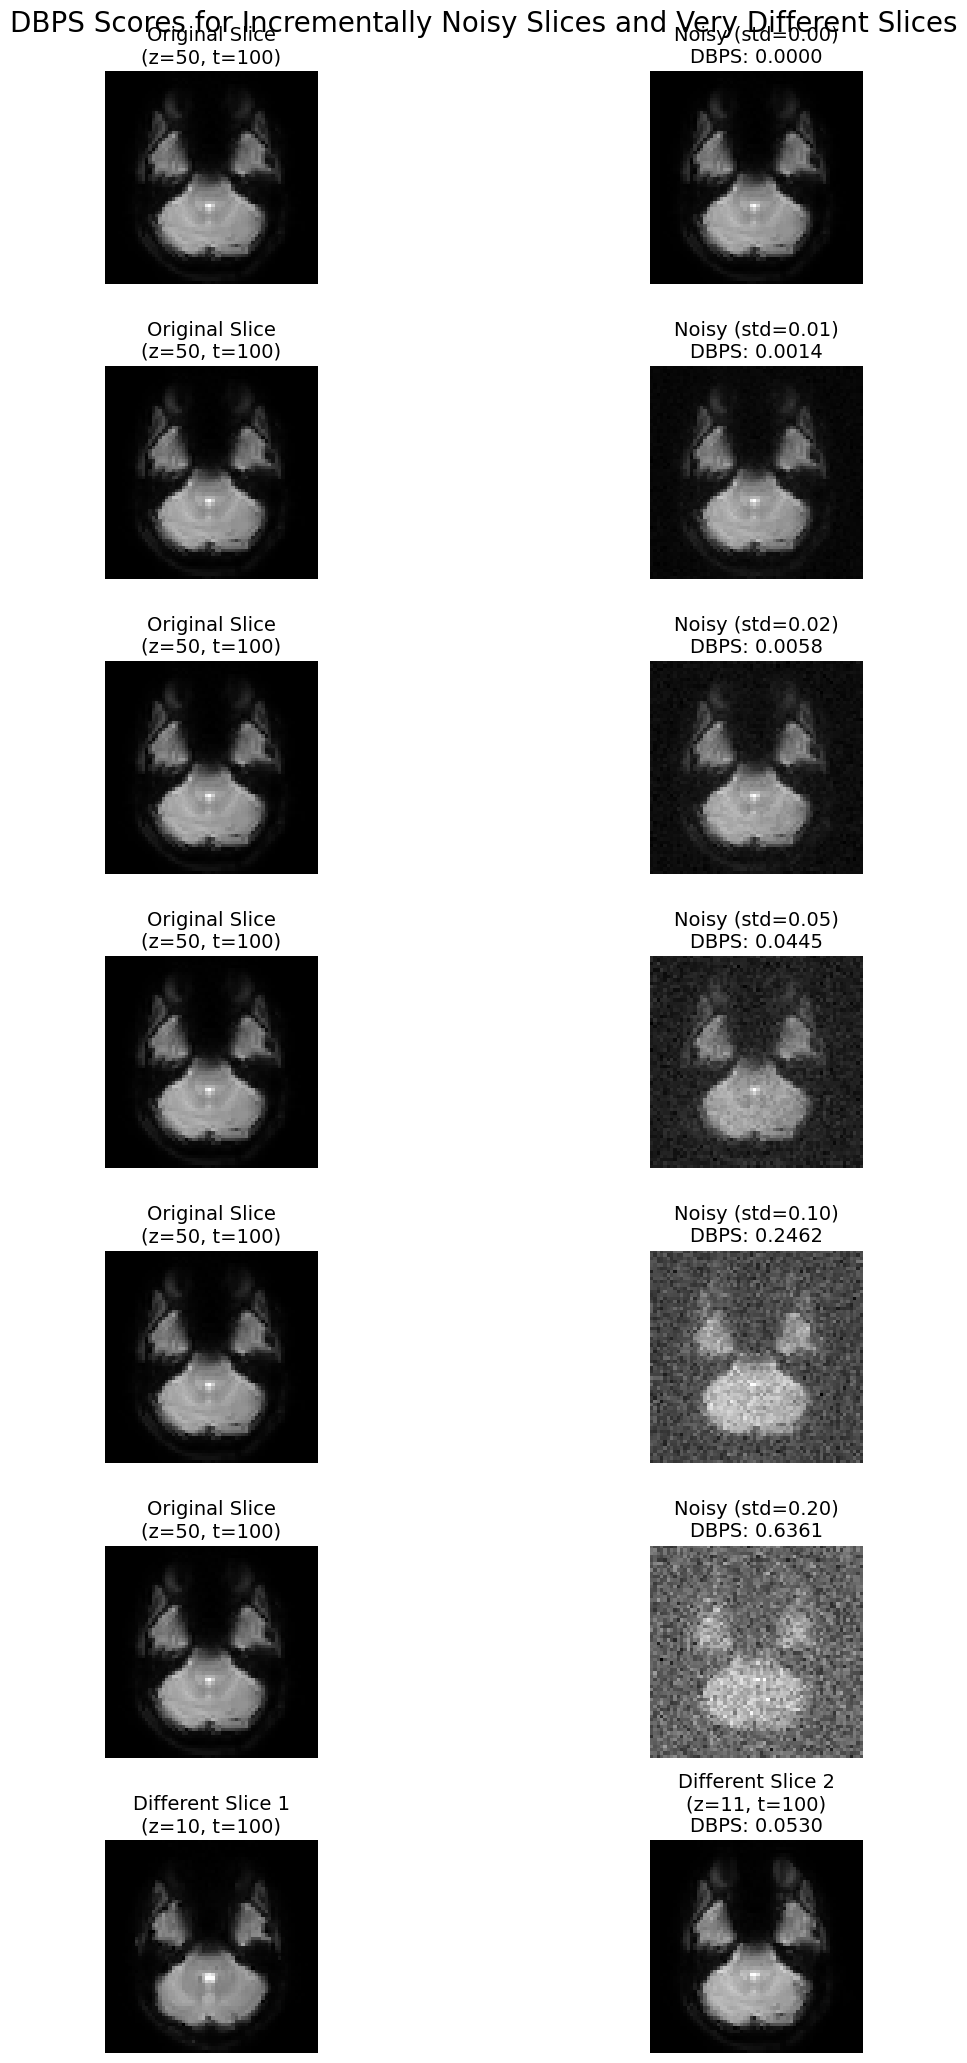

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# ─── Original slice ────────────────────────────────
z, t = 50, 100
slice_gt = gt[:, :, z, t].astype(np.float32)

# ─── Prepare noise levels ──────────────────────────
noise_levels = [0.00, 0.01, 0.02, 0.05, 0.1, 0.2]  # fractions of max intensity

# ─── Plotting ─────────────────────────────────────
fig, axes = plt.subplots(7, 2, figsize=(14, 21))  # 7 rows now!

for i, nl in enumerate(noise_levels):
    noise_std = nl * np.max(slice_gt)
    noise = np.random.normal(0, noise_std, slice_gt.shape).astype(np.float32)
    noisy_slice = slice_gt + noise

    # Convert to tensors
    tensor_gt = torch.from_numpy(slice_gt).unsqueeze(0).unsqueeze(0).to(device)
    tensor_noisy = torch.from_numpy(noisy_slice).unsqueeze(0).unsqueeze(0).to(device)

    # Compute DBPS score
    with torch.no_grad():
        score = dbps_metric(tensor_gt, tensor_noisy).item()

    # Plot original
    axes[i, 0].imshow(slice_gt, cmap='gray')
    axes[i, 0].set_title(f"Original Slice\n(z={z}, t={t})", fontsize=14)
    axes[i, 0].axis('off')

    # Plot noisy
    axes[i, 1].imshow(noisy_slice, cmap='gray')
    axes[i, 1].set_title(f"Noisy (std={nl:.2f})\nDBPS: {score:.4f}", fontsize=14)
    axes[i, 1].axis('off')

# ─── Final row: compare two very different slices ────────
z1, z2 = 10, 11
slice1 = gt[:, :, z1, t].astype(np.float32)
slice2 = gt[:, :, z2, t].astype(np.float32)

tensor1 = torch.from_numpy(slice1).unsqueeze(0).unsqueeze(0).to(device)
tensor2 = torch.from_numpy(slice2).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    diff_score = dbps_metric(tensor1, tensor2).item()

# Plot different slices
axes[-1, 0].imshow(slice1, cmap='gray')
axes[-1, 0].set_title(f"Different Slice 1\n(z={z1}, t={t})", fontsize=14)
axes[-1, 0].axis('off')

axes[-1, 1].imshow(slice2, cmap='gray')
axes[-1, 1].set_title(f"Different Slice 2\n(z={z2}, t={t})\nDBPS: {diff_score:.4f}", fontsize=14)
axes[-1, 1].axis('off')

plt.suptitle("DBPS Scores for Incrementally Noisy Slices and Very Different Slices", fontsize=20)
plt.tight_layout()
plt.show()
